# Downstream Analysis - R

Now we wrangle our data and plot results! Below, we do this using R tidyverse, cowplot, limma and multcomp packages

In [ ]:
#all_slow
#hide_output
library(cowplot)
library(limma)
library(multcomp)
library(tidyverse)

Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser


── Attaching packages ────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()



First, we read in results previously generated by py_clone_detector:

In [ ]:
#hide_output
count_df <- read_csv("data/example_results.csv")


── Column specification ───────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  int_img = col_character(),
  seg_ch = col_character(),
  int_img_ch = col_character(),
  seg_img = col_character(),
  GFP_clonepos = col_logical(),
  EC_pos = col_logical(),
  EE_pos = col_logical(),
  ECEE_pos = col_logical(),
  ISCorEB_pos = col_logical(),
  preEC_pos = col_logical()
)
ℹ Use `spec()` for the full column specifications.




In [ ]:
count_df %>% head()

int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,⋯,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,2196457,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,52757,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,2262648,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,67331,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,486.79847,0.4652274,98.69063,FALSE,4113516,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,486.79847,0.4652274,98.69063,FALSE,99772,TRUE,FALSE,FALSE,FALSE,FALSE


## Cell Proliferation - number of cells per clone

Out first aim is to determine whether there is a difference in the number of cells per clone. To do this, we first query an intensity image channel so that we do not count a cell (label) multiple times. Next, for simplicity, filter out columns not required for counting the number and type of cells per clone.

In [ ]:
#hide_output
count_df <- count_df %>%
  mutate(across(is_character, as_factor)) %>%
  filter(int_img_ch == 'C1') %>%
  select(matches("clone$|pos$|int_img")) %>%
  group_by(int_img, GFP_clone) %>%
  summarise(
    EC = sum(EC_pos),
    preEC = sum(preEC_pos),
    EE = sum(EE_pos),
    ECEE = sum(ECEE_pos),
    ISCorEB = sum(ISCorEB_pos)
  ) %>%
  mutate(
    clone_status = if_else(GFP_clone == 0, 'OC', 'IC'),
    genotype = if_else(str_detect(int_img, 'a1'), 'ctrl', 'mut'),
    total = EC + preEC + EE + ISCorEB
  )

Warning message:
“Predicate functions must be wrapped in `where()`.

  # Bad
  data %>% select(is_character)

  # Good
  data %>% select(where(is_character))

ℹ Please update your code.
This message is displayed once per session.”
`summarise()` has grouped output by 'int_img'. You can override using the `.groups` argument.



In [ ]:
count_df_tidy <-
  count_df %>% pivot_longer(cols = EC:ISCorEB,
                            names_to = 'cell_type',
                            values_to = 'cell_num') %>%
  mutate(cell_type = factor(cell_type, levels = c('ECEE', 'EE', 'EC', 'preEC', 'ISCorEB')))

In [ ]:
# create stacked bar plots
stacked_bar_mean <- count_df_tidy %>%
  filter(clone_status == 'IC') %>%
  ggplot(aes(fill = cell_type, y = cell_num, x = genotype)) +
  geom_bar(position = "stack",
           stat = "summary",
           fun = 'mean') +
  scale_fill_manual(values = c("#000000", "#95a5a6", "#F57171", "#539DC2", "#008b68")) +
  theme(legend.position = "none")

In [ ]:
stacked_bar_percentage <- count_df_tidy %>%
  ggplot(aes(fill = cell_type, y = cell_num, x = genotype)) +
  geom_bar(position = "fill", stat = 'identity') +
  facet_wrap(vars(clone_status)) +
  scale_fill_manual(values = c("#000000", "#95a5a6", "#F57171", "#539DC2", "#008b68"))

In [ ]:
# setup plot size, theme and text size
options(repr.plot.width=4, repr.plot.height=2)
theme_set(theme_cowplot(font_size=10))

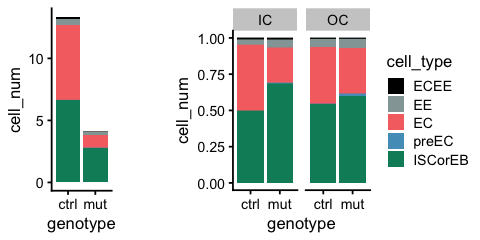

In [ ]:
ggdraw() +
  draw_plot(stacked_bar_mean, x = 0, width = .25) +
  draw_plot(stacked_bar_percentage, x = 0.35, width = .65)

In [ ]:
perc_df_tidy <-
  count_df_tidy %>% mutate(
    perc_cell_num = cell_num / total * 100,
    comp_g_cs_ct = as_factor(paste(genotype, clone_status, cell_type, sep = '_'))
  )

We next setup out desired contrasts using 

In [ ]:
contr <-
  limma::makeContrasts(mut_IC_ECEE - ctrl_IC_ECEE, 
                       mut_IC_EE - ctrl_IC_EE,
                       mut_IC_EC - ctrl_IC_EC,
                       mut_IC_preEC - ctrl_IC_preEC,
                       mut_IC_ISCorEB - ctrl_IC_ISCorEB,
                       mut_OC_ECEE - mut_IC_ECEE,
                       mut_OC_EE - mut_IC_EE,
                       mut_OC_EC - mut_IC_EC,
                       mut_OC_preEC - mut_IC_preEC,
                       mut_OC_ISCorEB - mut_IC_ISCorEB,
                       levels = unique(perc_df_tidy$comp_g_cs_ct))

In [ ]:
model <- lm(perc_cell_num ~ 0 + comp_g_cs_ct, perc_df_tidy)

G = glht(model, mcp(comp_g_cs_ct = t(contr)))

summary(G, test = adjusted('BH'))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: User-defined Contrasts


Fit: lm(formula = perc_cell_num ~ 0 + comp_g_cs_ct, data = perc_df_tidy)

Linear Hypotheses:
                                      Estimate Std. Error t value Pr(>|t|)    
mut_IC_ECEE - ctrl_IC_ECEE == 0         0.2103     1.9781   0.106 0.966218    
mut_IC_EE - ctrl_IC_EE == 0             3.5456     1.9781   1.792 0.146373    
mut_IC_EC - ctrl_IC_EC == 0           -22.9686     1.9781 -11.611  < 2e-16 ***
mut_IC_preEC - ctrl_IC_preEC == 0       0.3022     1.9781   0.153 0.966218    
mut_IC_ISCorEB - ctrl_IC_ISCorEB == 0  19.1207     1.9781   9.666  < 2e-16 ***
mut_OC_ECEE - mut_IC_ECEE == 0         -0.1712     3.7935  -0.045 0.966218    
mut_OC_EE - mut_IC_EE == 0             -0.1607     3.7935  -0.042 0.966218    
mut_OC_EC - mut_IC_EC == 0             14.2767     3.7935   3.763 0.000429 ***
mut_OC_preEC - mut_IC_preEC == 0        0.9692     3.7935   0.255 0.966218    
mut_OC_I